In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
# Param
num_epochs = 20
num_classes = 10
batch_size = 100
learning_rate = 0.002

In [3]:
#config
device = torch.device('cuda') # or 'cpu'

In [4]:
train_dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

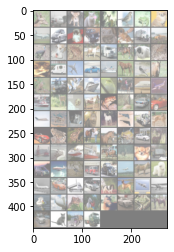

In [6]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images from dataset
dataiter = iter(train_loader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))

In [7]:
# CNN(Three layer)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,32, kernel_size=5, stride=1, padding=2),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=5, stride=1, padding=2),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(                                                
            nn.Conv2d(64,128, kernel_size=5, stride=1, padding=2),
            #nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(4 * 4 * 128, num_classes)                                

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)                                                    
        out = self.layer3(out)                                                      
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


model = ConvNet(num_classes).to(device)
print (model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)


In [8]:
# Loss and optimize
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [9]:

# Train
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

       
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))       

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/20], Step [500/500], Loss: 2.2950
Epoch [2/20], Step [500/500], Loss: 2.2900
Epoch [3/20], Step [500/500], Loss: 2.2656
Epoch [4/20], Step [500/500], Loss: 2.1970
Epoch [5/20], Step [500/500], Loss: 2.0557
Epoch [6/20], Step [500/500], Loss: 2.0817
Epoch [7/20], Step [500/500], Loss: 1.9625
Epoch [8/20], Step [500/500], Loss: 2.0899
Epoch [9/20], Step [500/500], Loss: 1.8776
Epoch [10/20], Step [500/500], Loss: 1.7907
Epoch [11/20], Step [500/500], Loss: 1.7378
Epoch [12/20], Step [500/500], Loss: 1.7667
Epoch [13/20], Step [500/500], Loss: 1.7937
Epoch [14/20], Step [500/500], Loss: 1.6406
Epoch [15/20], Step [500/500], Loss: 1.4656
Epoch [16/20], Step [500/500], Loss: 1.6336
Epoch [17/20], Step [500/500], Loss: 1.7309
Epoch [18/20], Step [500/500], Loss: 1.4601
Epoch [19/20], Step [500/500], Loss: 1.4670
Epoch [20/20], Step [500/500], Loss: 1.4156


In [10]:
# Test the model
model.eval() 
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Model Accuracy on the 10000 test images: {} %'.format(100 * correct / total))

Model Accuracy on the 10000 test images: 45.17 %
